In [1]:
import MDAnalysis as md # distances in Angstroem
from MDAnalysis.lib.pkdtree import PeriodicKDTree
from MDAnalysis.lib.distances import distance_array
from MDAnalysis.analysis.dihedrals import Ramachandran
from sklearn.cluster import KMeans
import mdtraj # necessary for dssp
import networkx as nx
import numpy as np
import h5py as h5
import warnings

In [2]:
class TransitionNetworks:
    topology = None
    trajectory = None
    nChains = 0
    state = []
    
    """The descriptors and corresponding cutoffs to use for constructing the transition matrix."""
    descriptors = {}
    
    def __init__(self, top=topology, traj=trajectory, nChains=nChains,\
                 desc=descriptors, state=state, binEdges=list(), nCapping=True,\
                 cCapping=True, h5File='transitionNetwork.hdf5'):
        self.top = top
        self.traj = traj
        self.universe = md.Universe(top, traj)
        self.nChains = nChains
        self.nAtomsPerChain = int(self.universe.trajectory.n_atoms/self.nChains)
        self.nResiduesPerChain = int(len(self.universe.residues)/self.nChains)
        self.nFrames = self.universe.trajectory.n_frames
        self.state = state
        self.binEdges = binEdges
        self.nCapping = nCapping
        self.cCapping = cCapping
        self.h5File = h5File
        
        """Sort the descriptors dictionary by cutoffs in decreasing order."""
        self.descriptors = {k: v for k, v in sorted(desc.items(), key=lambda item: -item[1])}

        """Generate array with cutoff values in decreasing order."""
        self.cutoffs = np.unique(list(self.descriptors.values()))[::-1]
        
        """Generate array to connect atom indices with residue names."""
        self.resnames = self.universe.atoms.resnames
        
        """Generate array to connect atom indices with residue indices."""
        self.resindices = self.universe.atoms.resindices
        
        """Generate a dictionary which enables to extract the atom index of a alpha carbon
        or nitrogen atom when giving a residue's index as input."""
        nAtomsDict = {}
        cAAtomsDict = {}
        for atomIdx, atom in enumerate(self.universe.atoms[:self.nAtomsPerChain], 0):
            if (atom.name == 'CA'):
                for chainIdx in range(nChains):
                    cAAtomsDict.update({atom.resnum + chainIdx*self.nResiduesPerChain: atomIdx + chainIdx*self.nAtomsPerChain})
            elif (atom.name == 'N'):
                for chainIdx in range(nChains):
                    nAtomsDict.update({atom.resnum + chainIdx*self.nResiduesPerChain: atomIdx + chainIdx*self.nAtomsPerChain})
        self.nAtomsDict = nAtomsDict
        self.cAAtomsDict = cAAtomsDict
    
    
    def _intermolecularContactPairs(self):
        """The largest cutoff value 'cutoff0' defines the search distance for the k-d tree."""
        cutoff0 = self.cutoffs[0]
        
        """All other cutoffs are stored in the array cutoffs1"""
        cutoffs1 = self.cutoffs[1:]

        with h5.File(self.h5File, 'a') as f:
            """Create/Check if group 'contactPairs' is present in the file. Structure
            of this group is: (nFrames, nCutoffs, contactPairs[cutoff])."""
            group = f.require_group(name='contactPairs')
            
            for frameIdx, frame in enumerate(self.universe.trajectory):
                frameIdx = str(frameIdx)
                
                """Extract the unit cell information 'box' and the concatenated positions
                'pos Concatenated' for every frame."""
                box = frame.dimensions
                posConcatenated = frame.positions
                
                """Initialize the periodic k-d tree 'tree' with the unit cell information.
                From MD analysis online documentation:
                Number of entries in leafs of the KDTree. If you suffer poor performance 
                you can play around with this number. Increasing the leafsize will speed
                up the construction of the KDTree but slow down the search."""
                tree = PeriodicKDTree(box=box, leafsize=5)
                
                """Reshape the positions array from shape (nAtomsPerChain*nChains, 3) to
                (nChains, nAtomsPerChain, 3) 'pos'."""
                pos = np.split(posConcatenated, self.nChains)

                """Build the k-d tree using the coordinates of one chain and then search
                all intermolecular contacts using the coordinates of the remaining chains."""
                contactPairs = list([] for d in self.cutoffs)
                for excludeChain in range(self.nChains-1):
                    
                    """Extract the coordinates of one chain."""
                    excludePos = pos[excludeChain]

                    """Build the k-d tree using these coordinates. From MD analysis online
                    documentation: 'cutoff': Specified cutoff distance to create duplicate images.
                    Typically equivalent to the desired search radius or the maximum of the 
                    desired cutoff radius."""
                    tree.set_coords(excludePos, cutoff=cutoff0)

                    """Extract the coordinates of the remaining chains."""
                    includeChains = [chain for chain in range(excludeChain+1, self.nChains)]
                    includePos = np.concatenate([pos[chain] for chain in includeChains])
                    
                    """Extract all intermolecular contact pairs within the cutoff0 and correct atom
                    indicies."""
                    for pair in tree.search_tree(includePos, cutoff0):                
                        atomIdxChainA = pair[1] + excludeChain*self.nAtomsPerChain
                        atomIdxChainB = pair[0] + (excludeChain+1)*self.nAtomsPerChain

                        """Compute the exact distance of this intermolecular distance pair using pbc."""
                        distance = distance_array(posConcatenated[atomIdxChainA],
                                                  posConcatenated[atomIdxChainB],
                                                  box=box)[0][0]

                        """Compare the calculated distance with the given cutoffs, stop if cutoff is
                        greater than the given value. 'depth' allows to return the 'stop cutoff' value
                        by self.cutoffs[depth]."""
                        depth = 0
                        for cValue in cutoffs1:
                            if (distance < cValue):
                                depth += 1
                            else:
                                break
                        
                        """Append the contact pair to the last undercut cutoff value array."""
                        contactPairs[depth].append(sorted([atomIdxChainA, atomIdxChainB]))

                """Store the intermolecular contact pairs array in the hdf5 file."""
                subGroup = group.require_group(name=frameIdx)
                for depth, data in enumerate(contactPairs):
                    subGroup.create_dataset(name=str(self.cutoffs[depth]), data=data)

                    
    def _oligomericSize(self):
        """Get the cutoff value for the descriptor function oligomeric size."""
        cutoff = self.descriptors['oligomericSize']
        
        """Open the hdf5 file and create the group 'oligomericSize' to store all information
        for this descriptor function. The structure of this group is (nFrames, nChains, any)"""
        with h5.File(self.h5File, 'a') as f:
            group = f.require_group(name='oligomericSize'+str(cutoff))
            group2 = f.require_group(name='oligomersInFrame'+str(cutoff))
            
            """Extract the contact pairs for every frame for the descriptor oligomeric size."""
            for frameIdx in f['contactPairs']:
                frameIdx = str(frameIdx)
                contactPairs = list(f['contactPairs'][frameIdx][str(cutoff)])
                
                """Array to be filled with information to identify which chains are in contact 
                within the cutoff value distance. Set is chosen because it has the helpful add
                feature, means that if the chain index is already included it is not appended
                multiple times, which would be the case when appending to a list."""
                oligomersInFrame = [set([chain]) for chain in range(self.nChains)]

                
                """Get the chain indices from the atoms in contact and add them to the associated
                chain sets."""
                for atomIdxChainA, atomIdxChainB in contactPairs:
                    chainIdxA = int(atomIdxChainA/self.nAtomsPerChain)
                    chainIdxB = int(atomIdxChainB/self.nAtomsPerChain)
                    oligomersInFrame[chainIdxA].add(chainIdxB)
                    oligomersInFrame[chainIdxB].add(chainIdxA)

                """This routine is necessary to identify larger oligomers, e.g. if chain 0 is in
                contact with chain 1, and chain 1 is in contact with chain 2 the adopted structure
                is a trimer (0-1-2). So, it units several separated sets."""
                for i in range(self.nChains):
                    for j in range(self.nChains):
                        if (i < j):
                            if (len(list(oligomersInFrame[i] & oligomersInFrame[j])) != 0):
                                united = oligomersInFrame[i].union(oligomersInFrame[j])
                                oligomersInFrame[i] = united
                                oligomersInFrame[j] = united

                """Export the data in the hdf5 file."""
                group.create_dataset(name=frameIdx, data=[len(chains) for chains in oligomersInFrame])
                
                subGroup = group2.require_group(name=frameIdx)
                for chainIdx, chainIndicesInStructure in enumerate(oligomersInFrame):
                    subGroup.create_dataset(name=str(chainIdx), data=list(chainIndicesInStructure))

    
    def _residuesWithAttribute(self, descriptorName=None, attribute=None):
        """The user can define an attribute group by augmentation or modification of
        the 'attributes' dictionary."""
        attributes = {'hydrophobic': ['GLY', 'ALA', 'VAL', 'LEU', 'ILE', 'PRO', 'PHE', 'MET', 'TRP'],
                      'polar': ['SER', 'THR', 'CYS', 'ASN', 'GLN', 'TYR']}
        residuesWithAttribute = attributes[attribute]
    
    
        """Get the cutoff value for the descriptor function."""
        cutoff = self.descriptors[descriptorName]
        
        """Open the hdf5 file and create the group 'descriptorName' to store all information
        for this descriptor function. The structure of this group is (nFrames, nChains, any)."""
        with h5.File(self.h5File, 'a') as f:
            group = f.require_group(name=descriptorName+str(cutoff))

            """Extract the contact pairs for every frame for the descriptor."""
            for frameIdx in f['contactPairs']:
                frameIdx = str(frameIdx)
                contactPairs = list(f['contactPairs'][frameIdx][str(cutoff)])

                """Array to be filled with information to identify which residues are in contact 
                within the cutoff value distance. Set is chosen because it has the helpful add
                feature, means that if the chain index is already included it is not appended
                multiple times, which would be the case when appending to a list."""
                residuesInContact = [set([]) for chain in range(self.nChains)]

                """Get the residue names of the atom indices and see if they belong to the
                chosen attribute."""
                for atomIdxChainA, atomIdxChainB in contactPairs:
                    residueNameA = self.resnames[atomIdxChainA]
                    residueNameB = self.resnames[atomIdxChainB]

                    if (residueNameA in residuesWithAttribute):
                        if (residueNameB in residuesWithAttribute):
                            """Get the residue index and the chain index of the atoms in contact."""
                            residueIdxA = self.resindices[atomIdxChainA]
                            residueIdxB = self.resindices[atomIdxChainB]
                            chainIdxA = int(atomIdxChainA/self.nAtomsPerChain)
                            chainIdxB = int(atomIdxChainB/self.nAtomsPerChain)

                            """Add the indices of the residues in contact with attribute to
                            the array 'residuesInContact'."""
                            residuesInContact[chainIdxA].add(residueIdxA)
                            residuesInContact[chainIdxB].add(residueIdxB)
                            
                """Export the data in the hdf5 file."""
                group.create_dataset(name=frameIdx, data=[len(x) for x in residuesInContact])
                
    
    def _hydrophobicContacts(self):
        self._residuesWithAttribute(descriptorName='hydrophobicContacts', attribute='hydrophobic')
    
    
    def _polarContacts(self):
        self._residuesWithAttribute(descriptorName='polarContacts', attribute='polar')
        
    
    def _compactness(self):
        if (self.nChains > 1):
            """These dictionaries are used later for the selection of atoms."""
            startIndicesDictionary = {}
            endIndicesDictionary = {}
            for chainIdx in range(self.nChains):
                startIndicesDictionary.update({chainIdx: chainIdx*self.nAtomsPerChain})
                endIndicesDictionary.update({chainIdx: chainIdx*self.nAtomsPerChain + self.nAtomsPerChain})
    
            """In order to use this descriptor function, the descriptor function '_oligomersize'
            has to be executed previously. If an oligomer is given, its overall compactness is
            determined, if not, the compactness of one chain is returned."""
            with h5.File(self.h5File, 'a') as f:
                
                """Get the cutoff value for the descriptor function oligomeric size."""
                cutoff = self.descriptors['oligomericSize']
                oligomersInFrame='oligomersInFrame'+str(cutoff)
                
                """Create the group 'compactness' if not present yet."""
                group = f.require_group(name='compactness')

                for frameIdx, _ in enumerate(self.universe.trajectory):
                    frameIdx = str(frameIdx)
                    
                    """Initialize array which is fed with compactness values later."""
                    compactnessValues = np.zeros(self.nChains)

                    """Get unique structures in frame."""
                    uniqueStructures = []
                    for structure in [list(f[oligomersInFrame][frameIdx][key])\
                                      for key in list(f[oligomersInFrame][frameIdx])]:
                        if (structure not in uniqueStructures):
                            uniqueStructures.append(structure)

                    for structure in uniqueStructures:
                
                        """Generate atom group with atoms, which are present in 'structure'."""
                        for idx, chainIdx in enumerate(structure):
                            if (idx == 0):
                                atomGroup = self.universe.atoms[startIndicesDictionary[chainIdx]:\
                                                                endIndicesDictionary[chainIdx]]
                            else:
                                atomGroup += self.universe.atoms[startIndicesDictionary[chainIdx]:\
                                                                endIndicesDictionary[chainIdx]]
                                
                        """Calculate the moment of inertia tensor for the structure and its
                        eigenvalues using periodic boundary conditions."""
                        momentOfInertiaTensor = atomGroup.moment_of_inertia(pbc=True)
                        eigenvalues = np.linalg.eigvals(momentOfInertiaTensor)

                        """Calculate the 'compactness' based on the lowest and highest eigenvalue."""
                        compactness = abs(round(10*min(eigenvalues)/max(eigenvalues)))

                        """Fill the previously initialized 'compactnessValues' array with the
                        compactness values."""
                        for chainIdx in structure:
                            compactnessValues[chainIdx] = compactness

                    """Save the data in the hdf5 file."""
                    group.create_dataset(name=frameIdx, data=compactnessValues)
                    
        else:
            with h5.File(self.h5File, 'a') as f:
                group = f.require_group(name='compactness')
                allAtoms = self.universe.select_atoms("all")
                
                for frameIdx, frame in enumerate(self.universe.trajectory):
                    compactness = np.zeros(1)
                    """Calculate the moment of inertia tensor for the structure and its
                    eigenvalues using periodic boundary conditions."""
                    momentOfInertiaTensor = allAtoms.moment_of_inertia(pbc=True)
                    eigenvalues = np.linalg.eigvals(momentOfInertiaTensor)
                    
                    """Calculate the 'compactness' based on the lowest and highest eigenvalue."""
                    compactness[0] = abs(round(10*min(eigenvalues)/max(eigenvalues)))
                
                    """Save the data in the hdf5 file."""
                    group.create_dataset(name=str(frameIdx), data=compactness)
                      
                
    def _intermolecularSaltBridgeContacts(self):        
        """At first an atom group containing all atoms of chain A is generated. It is important to
        mention that all chains have to be identical!"""
        atomsChainA = self.universe.atoms[:self.nAtomsPerChain]

        """Now the bonds between the selected atoms are guessed and the elements of these atoms are
        identified."""
        
        "***!!Could be optimized using mdtraj bonds!!***'"
        atomsChainA.guess_bonds()
        elements = [atom.type for atom in atomsChainA]
        
        """Initialize positive 'pos' and negative 'neg' charge of that chain and the lists where
        the charged atoms are stored, positively charged atom indices are stored in 
        'saltBridgeAcceptorsChainA', negatively charged atom indices are stored in
        saltBridgeDonorsChainA, respectively."""
        pos = 0
        saltBridgeAcceptorsChainA = list()
        neg = 0
        saltBridgeDonorsChainA = list()
        
        for atomIdx, element in enumerate(elements):
            
            """If atom with index 'atomIdx' is a nitrogen atom and has four binding partners 
            (corresponding to a charge of +1) raise the counter of positively charged atoms 
            'pos' by one and add 'atomIdx' to the list of positively charged atoms 
            'saltBridgeAcceptorsChainA'.""" 
            if (element == 'N'):
                bondingDegree = 0
                for bond in atomsChainA.bonds:
                    if (atomIdx in bond.indices):
                        bondingDegree += 1
                
                if (bondingDegree == 4):
                    saltBridgeAcceptorsChainA.append(atomIdx)
                    pos += 1

            elif (element == 'O'):
                """If atom with index 'atomIdx' is an oxygen atom and has only one binding partners
                with a single bond (corresponding to a charge of -1) and the next atom is also an
                oxygen atom (allows identification of carboxylic groups COO-) lower the counter of 
                negatively charged atoms 'neg' by one and add  'atomIdx' to the list of negatively
                charged atoms 'saltBridgeDonorsChainA'."""   
                bondingDegree = 0
                for bond in atomsChainA.bonds:
                    if (atomIdx in bond.indices):
                        try:
                            if (elements[atomIdx + 1] == 'O'):
                                bondingDegree += 1
                                
                        except IndexError:
                            pass
                        
                """Also append the index of the next atom, because the charge can be distributed among
                both oxygen atoms."""
                if (bondingDegree == 1):
                    saltBridgeDonorsChainA.append(atomIdx)
                    neg -= 1
        
        """Total charge of chain A is simply the sum of positively and negatively counted atoms."""
        chargeChainA = pos + neg
        
        saltBridgeAcceptorsChainA = np.array(saltBridgeAcceptorsChainA)
        saltBridgeDonorsChainA = np.array(saltBridgeDonorsChainA)
        
        """Initialize and fill lists in order to generalize the atom indices for all chains."""
        saltBridgeAcceptors = list()
        saltBridgeDonors = list()
        
        if (len(saltBridgeAcceptorsChainA) != 0):
            for chainIdx in range(self.nChains):
                saltBridgeAcceptors.append(saltBridgeAcceptorsChainA + chainIdx*self.nAtomsPerChain)            

        else:
            for chainIdx in range(self.nChains):
                saltBridgeAcceptors.append([])  
                
                
        if (len(saltBridgeDonorsChainA) != 0):
            for chainIdx in range(self.nChains):
                saltBridgeDonors.append(saltBridgeDonorsChainA + chainIdx*self.nAtomsPerChain)
        
        else:
            for chainIdx in range(self.nChains):
                saltBridgeDonors.append([])  
                
        
        """Generate a list with atom indices of possible salt bridge contact pairs."""
        descriptorName = 'intermolecularSaltBridgeContacts'
        possibleIntermolecularSaltBridgePairs = list()
        findPairs = list()
        for chainIdxA, acceptors in enumerate(saltBridgeAcceptors):
            for chainIdxB, donors in enumerate(saltBridgeDonors):

                """Exclude intramolecular salt bridge pairs."""
                if (chainIdxA != chainIdxB):
                    for acceptor in acceptors:
                        for donor in donors:
                            if ([acceptor, donor] not in findPairs):
                                possibleIntermolecularSaltBridgePairs.append([np.sort([acceptor, donor+idx])\
                                                                              for idx in range(2)])
                                for idx in range(2):
                                    findPairs.append([acceptor, donor+idx])
        del findPairs
        
        saltBridgeDict = {}
        for idx, pairs in enumerate(possibleIntermolecularSaltBridgePairs):
            for pair in pairs:
                saltBridgeDict.update({str(pair): idx})
        
        nDifferntSaltBridgePairs = len(possibleIntermolecularSaltBridgePairs)
        
        """Get the cutoff value for the descriptor function intermolecularSaltBridgeContacts."""
        cutoff = self.descriptors[descriptorName]
    
        """Open the hdf5 file and create the group 'desc' to store all information
        for this descriptor function. The structure of this group is (nFrames, nChains)."""
        with h5.File(self.h5File, 'a') as f:
            group = f.require_group(name=descriptorName+str(cutoff))

            """Extract the contact pairs for every frame for the descriptor."""
            for frameIdx in range(self.nFrames):
                frameIdx = str(frameIdx)
                saltBridgeContacts = np.zeros(self.nChains)
                noContactInFrame = [True for pairIdx in range(nDifferntSaltBridgePairs)]
                
                contactPairs = list(f['contactPairs'][frameIdx][str(cutoff)])
                for contactPair in contactPairs:
                    for possibleSaltBridgePairs in possibleIntermolecularSaltBridgePairs:
                        for pair in possibleSaltBridgePairs:
                            if np.allclose(pair, np.sort(list(contactPair))):
                                
                                if noContactInFrame[saltBridgeDict[str(pair)]]:
                                    chainIdxA = int(contactPair[0]/self.nAtomsPerChain)
                                    saltBridgeContacts[chainIdxA] += 1
                                    chainIdxB = int(contactPair[1]/self.nAtomsPerChain)
                                    saltBridgeContacts[chainIdxB] += 1
                                    
                                    noContactInFrame[saltBridgeDict[str(pair)]] = False
                                    break

                """Export the data in the hdf5 file."""
                group.create_dataset(name=frameIdx, data=saltBridgeContacts)
        
        
    def _residuesInBeta(self, simplified=False):
        """For this function, the package mdtraj is used as it enables to compute the secondary
        structure using dssp. Please note that the simplified dssp codes ('simplified=True') 
        are ‘E’== Strand (either of the ‘E’, or ‘B’ non-simplified codes, which are ‘B’ : Residue
        in isolated beta-bridge ‘E’ : Extended strand, participates in beta ladder."""
        
        """Load the trajectory using mdtraj as 'trajec'."""
        trajec = mdtraj.load(self.traj, top=self.top)

        """Open the hdf5 file and create the group 'residuesInBeta' to store all information
        for this descriptor function. The structure of this group is (nFrames, nChains)."""
        with h5.File(self.h5File, 'a') as f:
            group = f.require_group(name='residuesInBeta')

            """Compute the secondary structures in each frame and count the 'E's (strands, when using
            simplified code assignments)."""
            for frameIdx, secondaryStructure in enumerate(mdtraj.compute_dssp(trajec, simplified=simplified)):
                residuesInBeta = list()
                for residuesInBetaChain in np.split(secondaryStructure, self.nChains):
                    residuesInBeta.append(np.count_nonzero(residuesInBetaChain == 'E'))
                
                """Store the number of residues in beta for each frame in the hdf5 file."""
                group.create_dataset(name=str(frameIdx), data=residuesInBeta)
                
    
    """From here on, a few functions follow which are necessary to compute the nematic and polar
    order parameters."""
    def _tensorOrderParameterQ(self, vector):
        """Computation of the ordering matrix Q as defined in:
        'Thermodynamic analysis of structural transitions during GNNQQNY aggregation'
        from Kenneth L. Osborne,  Michael Bachmann, and Birgit Strodel published in
        Proteins 2013; 81:1141–1155."""
        Q = np.zeros((3, 3))
        for a, valueA in enumerate(vector):
          
            """Since Q is a symmetric matrix, Qab=Qba applies, such that the loop
            can be shortened."""
            for b, valueB in enumerate(vector[a::]):
                if (a == b):
                    Qab = 3*valueA*valueB - 1
                    Q[a][b] = Qab
                    Q[b][a] = Qab
                else:
                    Qab = 3*valueA*valueB
                    Q[a][b] = Qab
                    Q[b][a] = Qab
            return (Q)
        
    def _director(self, vectors):
        """Computation of the direction 'director' most molecules are aligned to. The director
        is equal to the eigenvector corresponding to the largest eigenvalue of the ordering
        matrix Q."""
        Q = np.zeros((3, 3))
        
        """Compute Q for every vector."""
        for vector in vectors:
            Q += self._tensorOrderParameterQ(vector)        
        
        """Compute the averaged ordering matrix Q."""
        Q /= (2*len(vectors))

        """Determine the eigenvalues and associated eigenvectors of Q."""
        eigenValues, eigenVectors = np.linalg.eigh(Q)
        
        """Sort the eigenvalues and associated eigenvectors in decreasing order."""
        idx = eigenValues.argsort()[::-1]   
        eigenValues = eigenValues[idx]
        eigenVectors = eigenVectors[:,idx]

        """Return the director by extracting the eigenvector correspoding to the largest
        eigenvalue."""
        director = eigenVectors[:,0]   
        return (director)

    
    def _orderParametersComputation(self, vectors):
        """Normalize the vectors."""
        vectorsNotNormalized = vectors.copy()
        vectors = list()
        for vector in vectorsNotNormalized:
            vectors.append(vector/np.linalg.norm(vector))
            
        """Compute the director using the normalized vectors."""
        director = self._director(vectors)
        
        """Compute the polar and nematic order parameters."""
        polarOrderParameter = 0
        nematicOrderParameter = 0
        for vector in vectors:
            polarOrderParameter += np.matmul(vector, director)
            nematicOrderParameter += 3*np.matmul(vector, director)**2 - 1
            
        """Use the absolut value, because negative only occur as result of the algorithm's
        used for computing the eigenvectors."""
        polarOrderParameter = abs(polarOrderParameter/len(vectors))
        nematicOrderParameter = abs(nematicOrderParameter/(2*len(vectors)))
        return (polarOrderParameter, nematicOrderParameter)
    
    
    def _orderParameters(self, simplified=False):
        """Load the trajectory using mdtraj as 'trajec'."""
        trajec = mdtraj.load(self.traj, top=self.top)
        
        """Compute the secondary structure patterns for each frame."""
        dssp = mdtraj.compute_dssp(trajec, simplified=simplified)
    
        """In order to use this descriptor function, the descriptor function '_oligomersize'
        has to be executed previously. If an oligomer is given, the vectors belonging to both
        chain are used for the computation of the order paramters, if not, the order parameters
        of one chain with at least to segments are returned."""
        
        with h5.File(self.h5File, 'a') as f:
            """Get the cutoff value for the descriptor function oligomeric size."""
            cutoff = self.descriptors['oligomericSize']
            oligomersInFrame='oligomersInFrame'+str(cutoff)

            group = f.require_group(name='orderParameter')

            for frameIdx, (secondaryStructure, positions) in enumerate(zip(dssp, self.universe.trajectory)):
                """Check if beta pattern is recognized in frame."""
                
                frameIdx = str(frameIdx)
                descriptorValues = np.zeros(self.nChains)
                if ('E' in secondaryStructure):
                    """Get the residue indices belonging to dssp attribute 'E'."""
                    residueIndices = np.where(secondaryStructure == 'E')[0]+1

                    """Extract the beta segments."""
                    diff = residueIndices[1:] - residueIndices[:-1]
                    residueIndices = np.array_split(residueIndices, np.where(diff != 1)[0]+1)

                    """Check if these segments are composed of at least two residues
                    and then append the residues to the array 'segments2'."""
                    segments2 = list()
                    for segment in residueIndices:
                        if (len(segment) > 1):
                            segments2.append(segment)
                        else:
                            pass

                    """Check if there are at least two segments composed of at least two residues."""
                    if (len(segments2) > 1):
                        uniqueStructures = []
                        for structure in [list(f[oligomersInFrame][frameIdx][key])\
                                          for key in list(f[oligomersInFrame][frameIdx])]:
                            if (structure not in uniqueStructures):
                                uniqueStructures.append(structure)
                                
                        Segments = list([] for unique in uniqueStructures)
                        breakStatement = False
                        for segment in segments2:
                            for idx, uniqueStructure in enumerate(uniqueStructures):
                                for chain in uniqueStructure:
                                    if (int(segment[0]/self.nResiduesPerChain) == chain):
                                        Segments[idx].append(segment)
                        
                        for idx, segments in enumerate(Segments):
                            if (len(segments) > 1):
                                """Compute the NC vector of these segments and append them to 'vectors'."""
                                vectors = []
                                for segment in segments:
                                    nAtomPosition = positions.positions[self.nAtomsDict[segment[0]]]
                                    cAAtomPosition = positions.positions[self.cAAtomsDict[segment[-1]]]
                                    vectors.append(nAtomPosition - cAAtomPosition)
        
                                """Compute the polar and nematic order parameter using the set of vectors
                                'vectors'."""
                                polarOrderParameter, nematicOrderParameter = self._orderParametersComputation(vectors)
                                
                                if (nematicOrderParameter >= 0.7):
                                    if (polarOrderParameter >= 0.7):
                                        "parallel"
                                        for idx in uniqueStructures[idx]:
                                            descriptorValues[idx] = 1

                                    elif (polarOrderParameter <= 0.4):
                                        "antiparallel"
                                        for idx in uniqueStructures[idx]:
                                            descriptorValues[idx] = -1
                
                """Store the order parameter descriptor value for each frame and oligomer
                in the hdf5 file."""
                group.create_dataset(name=str(frameIdx), data=descriptorValues)

    
    def _distanceBetweenTwoAtoms(self, frame=0, indices=list()):
        """Get the box dimensions if the frame."""
        box = frame.dimensions
        
        """Get the positions of the atoms given."""
        posConcatenated = frame.positions[indices]
        
        """Compute and return the distance using pbc. The unit of the distance
        is angstrom."""
        return (distance_array(posConcatenated[0], posConcatenated[1], box=box)[0][0])
    
    
    def _nCDistances(self):
        """'binEdges' is an array, which is used as follows:
            example: binEdges = [5.0, 14.5, 20]
                     bin1 = [0.0, 5.0]
                     bin2 = (5.0, 14.5]
                     bin3 = (14.5, 20.0]
                     bin4 = (20.0, infinity).
            So len(binEdges)+1 bins are generated."""
        
        """Get the N and C terminus atom indices. Consider cappings, which are the input
        in boolian format."""
        if self.nCapping:
            nTerminusIndices = self.universe.select_atoms("resnum 2 and name N").indices
        else:
            nTerminusIndices = self.universe.select_atoms("resnum 1 and name N").indices
            
        if self.cCapping:
            selectionString = "resnum " + str(self.nResiduesPerChain -1) + " and name CA"
            cTerminusIndices = self.universe.select_atoms(selectionString).indices
        else:
            selectionString = "resnum " + str(self.nResiduesPerChain) + " and name CA"
            cTerminusIndices = self.universe.select_atoms(selectionString).indices        
        
        highestBinIndex = len(self.binEdges) + 1
        
        with h5.File(self.h5File, 'a') as f:
            """Generate the group 'nCDistances' in the hdf5 file."""
            group = f.require_group(name='nCDistances')

            """Compute the distance and assign it to a bin."""
            for frameIdx, frame in enumerate(self.universe.trajectory):
                nCDistances = np.zeros(self.nChains)                
                for chainIdx, (nTerminusAtomIdx, cTerminusAtomIdx) \
                in enumerate(zip(nTerminusIndices, cTerminusIndices)):
                    indices = [nTerminusAtomIdx, cTerminusAtomIdx]
                    distance = self._distanceBetweenTwoAtoms(indices=indices, frame=frame)
                    
                    binned = False
                    for descriptorValue, edge in enumerate(self.binEdges, 1):
                        if (distance <= edge):
                            nCDistances[chainIdx] = descriptorValue
                            binned = True
                            break
                            
                    if not binned:
                        nCDistances[chainIdx] = highestBinIndex
                
                group.create_dataset(name=str(frameIdx), data=nCDistances)
    
    def _ramachandran(self):
        warnings.filterwarnings("ignore", message="Cannot determine phi and psi angles for the first or last residues")
        """This function is only valid for monomers! Keep in mind that cluster indices
        can differ."""
        allAtoms = self.universe.select_atoms("all")

        phis, psis = Ramachandran(allAtoms).run().angles.T 
        phis = phis.T
        psis = psis.T
        
        X = list()
        for xArr, yArr in zip(phis[:, :], psis[:, :]):
            for x, y in zip(xArr, yArr):
                X.append([x, y])
        X = np.array(X)
        
        kmeans = KMeans(n_clusters=2, random_state=0).fit(X)
        xCluster, yCluster = kmeans.cluster_centers_.T
        
        with h5.File(self.h5File, 'a') as f:
            group = f.create_group('ramachandran')
            for frameIdx, (xArr, yArr) in enumerate(zip(phis[:, :], psis[:, :])):
                value = 0
                for x, y in zip(xArr, yArr):
                    value += kmeans.predict([[x, y]])[0]
                group.create_dataset(name=str(frameIdx), data=[value])
    
    def _generateTransitionMatrix(self):
        """Generate the key names for the state defining functions, which may either be composed
        of the descriptors name or of the descriptors name and the associated cutoff value."""
        descriptorKeys = []
        for descriptorName in self.state:
            try:
                descriptorKeys.append(descriptorName + str(self.descriptors[descriptorName]))
            except KeyError:
                descriptorKeys.append(descriptorName)
        
        differentStatesList = []
        populationOfStatesDict = {}
        transitionMatrixDict = {}
        countIdx = 0
        with h5.File(self.h5File, 'r') as f:
            states = []
            for frame in range(self.nFrames):
                """Extract the states in every frame."""
                statesInFrame = list([] for chain in range(self.nChains))
                for key in descriptorKeys:
                    for chainIdx, value in enumerate(f[key][str(frame)]):
                        statesInFrame[chainIdx].append(int(value))
                
                for state in statesInFrame:
                    """If a state did not occur yet, append it to the list 'differenStatesList',
                    update its population and generate an entry in the dictionary 
                    'transitionMatrixDict' to later relate the entries in the 'transitionMatrix' with
                    transitions between states, in other words to relate indices <-> states."""
                    if (state not in differentStatesList):
                        differentStatesList.append(state)
                        populationOfStatesDict.update({tuple(state): 1})
                        transitionMatrixDict.update({tuple(state): countIdx})
                        countIdx += 1
    
                    else:
                        """If a state is already known, increase its population by one
                        update its population."""
                        population = populationOfStatesDict[tuple(state)]
                        population += 1
                        populationOfStatesDict.update({tuple(state): population})
                
                """Append the states observed in this frame to the overall array 'states'."""
                states.append(statesInFrame)
                                
            """Get the number of different states which have been observed along the
            trajectory."""
            differentStates = len(differentStatesList)
            states = np.array(states)
            
            """Initialize the transition matrix."""
            transitionMatrix = np.zeros((differentStates, differentStates), dtype=int)
            
            """Fill the transition matrix with transition values by counting all observed
            transitions between two states."""
            for chainIdx in range(self.nChains):
                stateHistory = states[:, chainIdx, :]
                for state1, state2 in zip(stateHistory[:-1], stateHistory[1:]):
                    idx1 = transitionMatrixDict[tuple(state1)]
                    idx2 = transitionMatrixDict[tuple(state2)]
                    transitionMatrix[idx1][idx2] += 1
        return (transitionMatrix, transitionMatrixDict)

    
    def _generateNetwork(self, minPopulation=0.0, minTransition=0.0, gexfName="network.gexf"):
        """This function generates a .gexf file which can be visualized using the
        program 'Gephi'. This files contains the following information:
            - population of a state can be visualized by a node's size
            - the name of a node is the state
            - the amount of transition between two states is encoded in the
              line thickness
            - the direction of the transition is read to be clockwise.
            
        Futhermore the user is asked to give 'minPopulation' as input, which is a threshold
        for only considering nodes possesing with at least 'minPopulation'*100 percent population
        of the maximum observed population"""
        
        
        transitionMatrix, transitionMatrixDict = self._generateTransitionMatrix()
        transitionMatrixNonDiagonal = transitionMatrix.copy()
        for idx,_ in enumerate(transitionMatrixNonDiagonal):
            transitionMatrixNonDiagonal[idx][idx] = 0
                
        """Get the maximum values for a node pouplation and a transition."""
        maxPopulation = max(np.diag(transitionMatrix))
        maxTransition = np.max(transitionMatrixNonDiagonal)
        
        """Generate a dictionary with nodes and normalized population, which are at least greater than
        'minPopulation'."""
        nodesDict = {}
        for state, size in zip(transitionMatrixDict.keys(), np.diagonal(transitionMatrix)):
            fraction = size/maxPopulation
            if (fraction >= minPopulation):
                nodesDict.update({state: size})

        """Only consider normalized transitions with a value of at least 'minTransition'."""
        edgesDict = {}
        for state1, (idx1, row) in zip(transitionMatrixDict.keys(), enumerate(transitionMatrix)):
            for state2, (idx2, transition) in zip(transitionMatrixDict.keys(), enumerate(row)):
                if (idx1 != idx2 and transition != 0):
                    if (state1 in nodesDict.keys() and state2 in nodesDict.keys()):
                        fraction = transition/maxTransition
                        if (fraction >= minTransition):
                            edgesDict.update({(state1, state2): transition})

        G = nx.DiGraph()
        for k, v in nodesDict.items():
            G.add_node(k, size=float(v))
        for k, v in edgesDict.items():
            G.add_edge(k[0], k[1], weight=float(v))
        nx.draw(G)
        nx.write_gexf(G, gexfName)
        
    
    def _OSError(self, function):
        try:
            function()
        except OSError:
            pass
        except ValueError:
            pass
        
    def generateNetwork(self, minPopulation=0.0, minTransition=0.0, gexfName="network.gexf"):
        for state in self.state:
            if (state == 'oligomericSize'):
                self._OSError(self._intermolecularContactPairs)
                self._OSError(self._oligomericSize)

            elif (state == 'intermolecularSaltBridgeContacts'):
                self._OSError(self._intermolecularContactPairs)
                self._OSError(self._intermolecularSaltBridgeContacts)
                
            elif (state == 'compactness'):
                if (self.nChains > 1):
                    self._OSError(self._intermolecularContactPairs)
                    self._OSError(self._oligomericSize)
                    self._OSError(self._compactness)
                else:
                    self._OSError(self._compactness)
     
            elif (state == 'orderParameter'):
                self._OSError(self._intermolecularContactPairs)
                self._OSError(self._oligomericSize)                
                self._OSError(self._orderParameters)
                
            elif (state == 'hydrophobicContacts'):
                self._OSError(self._intermolecularContactPairs)
                self._OSError(self._hydrophobicContacts)
                
            elif (state == 'polarContacts'):
                self._OSError(self._intermolecularContactPairs)
                self._OSError(self._polarContacts)
                
            elif (state == 'residuesInBeta'):
                self._OSError(self._residuesInBeta)
            
            elif (state == 'nCDistances'):
                self._OSError(self._nCDistances)
                
            elif (state == 'ramachandran'):
                self._OSError(self._ramachandran)
                
        self._generateNetwork(minPopulation=minPopulation, minTransition=minTransition, gexfName=gexfName)

Wenn ein Cutoff mit einer Nachkommastelle gegeben ist, müssen alle anderen auch mit einer Nachkommastelle gegeben werden!

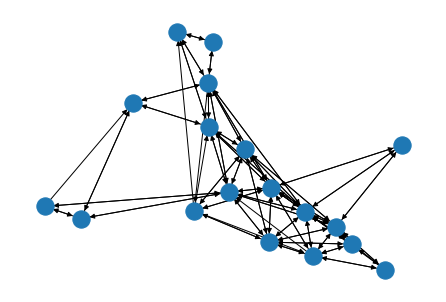

In [3]:
top ='0-5_cc.pdb'
traj ='0-10_cc_skip10.xtc'
desc = {'oligomericSize': 5.0, 'intermolecularSaltBridgeContacts': 4.0}
state = ['oligomericSize', 'intermolecularSaltBridgeContacts', 'orderParameter', 'residuesInBeta']
nChains = 2
tn = TransitionNetworks(top=top, traj=traj, desc=desc, nChains=nChains, state=state)
tn.generateNetwork(minPopulation=0.01, minTransition=0.01)